In [1]:
import lightning as L
from dotenv import load_dotenv
from lightning.pytorch.loggers import CSVLogger
from vector_vis_graph import WeightMethod

from vispool.glue.datamodule import GLUEDataModule
from vispool.model.gcn import PoolStrategy
from vispool.model.model import VisualVVGTransformer
from vispool.vvg import VVGType

In [2]:
load_dotenv()

SEED = 42
TASK_NAME = "rte"
MODEL_CHECKPOINT = "distilbert-base-uncased"
# MODEL_CHECKPOINT = "albert-base-v2"
VVG_TYPE = VVGType.NATURAL
POOL = PoolStrategy.CLS
BATCH_SIZE = 32
NUM_WORKERS = 8
ENC_LR = 1e-5
GCN_LR = 1e-2
HIDDEN_DIM = 128
DROPOUT = 0.1
PENETRABLE_LIMIT = 0
MAX_EPOCHS = 2
RUN_BASELINE = False
DEGREE_NORMALIZE = False
LAYER_NORM = False

In [3]:
logger = CSVLogger(save_dir="logs", name=TASK_NAME)

# Model
L.seed_everything(SEED)
dm = GLUEDataModule(
    MODEL_CHECKPOINT,
    task_name=TASK_NAME,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

model = VisualVVGTransformer(
    MODEL_CHECKPOINT,
    task_name=TASK_NAME,
    encoder_lr=ENC_LR,
    gcn_lr=GCN_LR,
    gcn_hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    pool=POOL,
    vvg_type=VVG_TYPE,
    weight_method=WeightMethod.UNWEIGHTED,
    penetrable_limit=PENETRABLE_LIMIT,
    directed=False,
    degree_normalize=DEGREE_NORMALIZE,
    parameter_search=False,
    layer_norm=LAYER_NORM,
)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=MAX_EPOCHS,
    deterministic=True,
    logger=logger,
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
print("Training vvg on:", TASK_NAME)
trainer.fit(model, datamodule=dm)

Training vvg on: rte


Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | encoder | DistilBertModel | 66.4 M
1 | gcn     | OverallGCN      | 106 K 
--------------------------------------------
66.5 M    Trainable params
0         Non-trainable params
66.5 M    Total params
265.879   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [16]:
document_graphs = [batch[0].cpu().numpy() for batch in model.graphs]
document_graphs

[array([[0., 1., 1., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]], dtype=float32),
 array([[0., 1., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [1., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]], dtype=float32)]

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

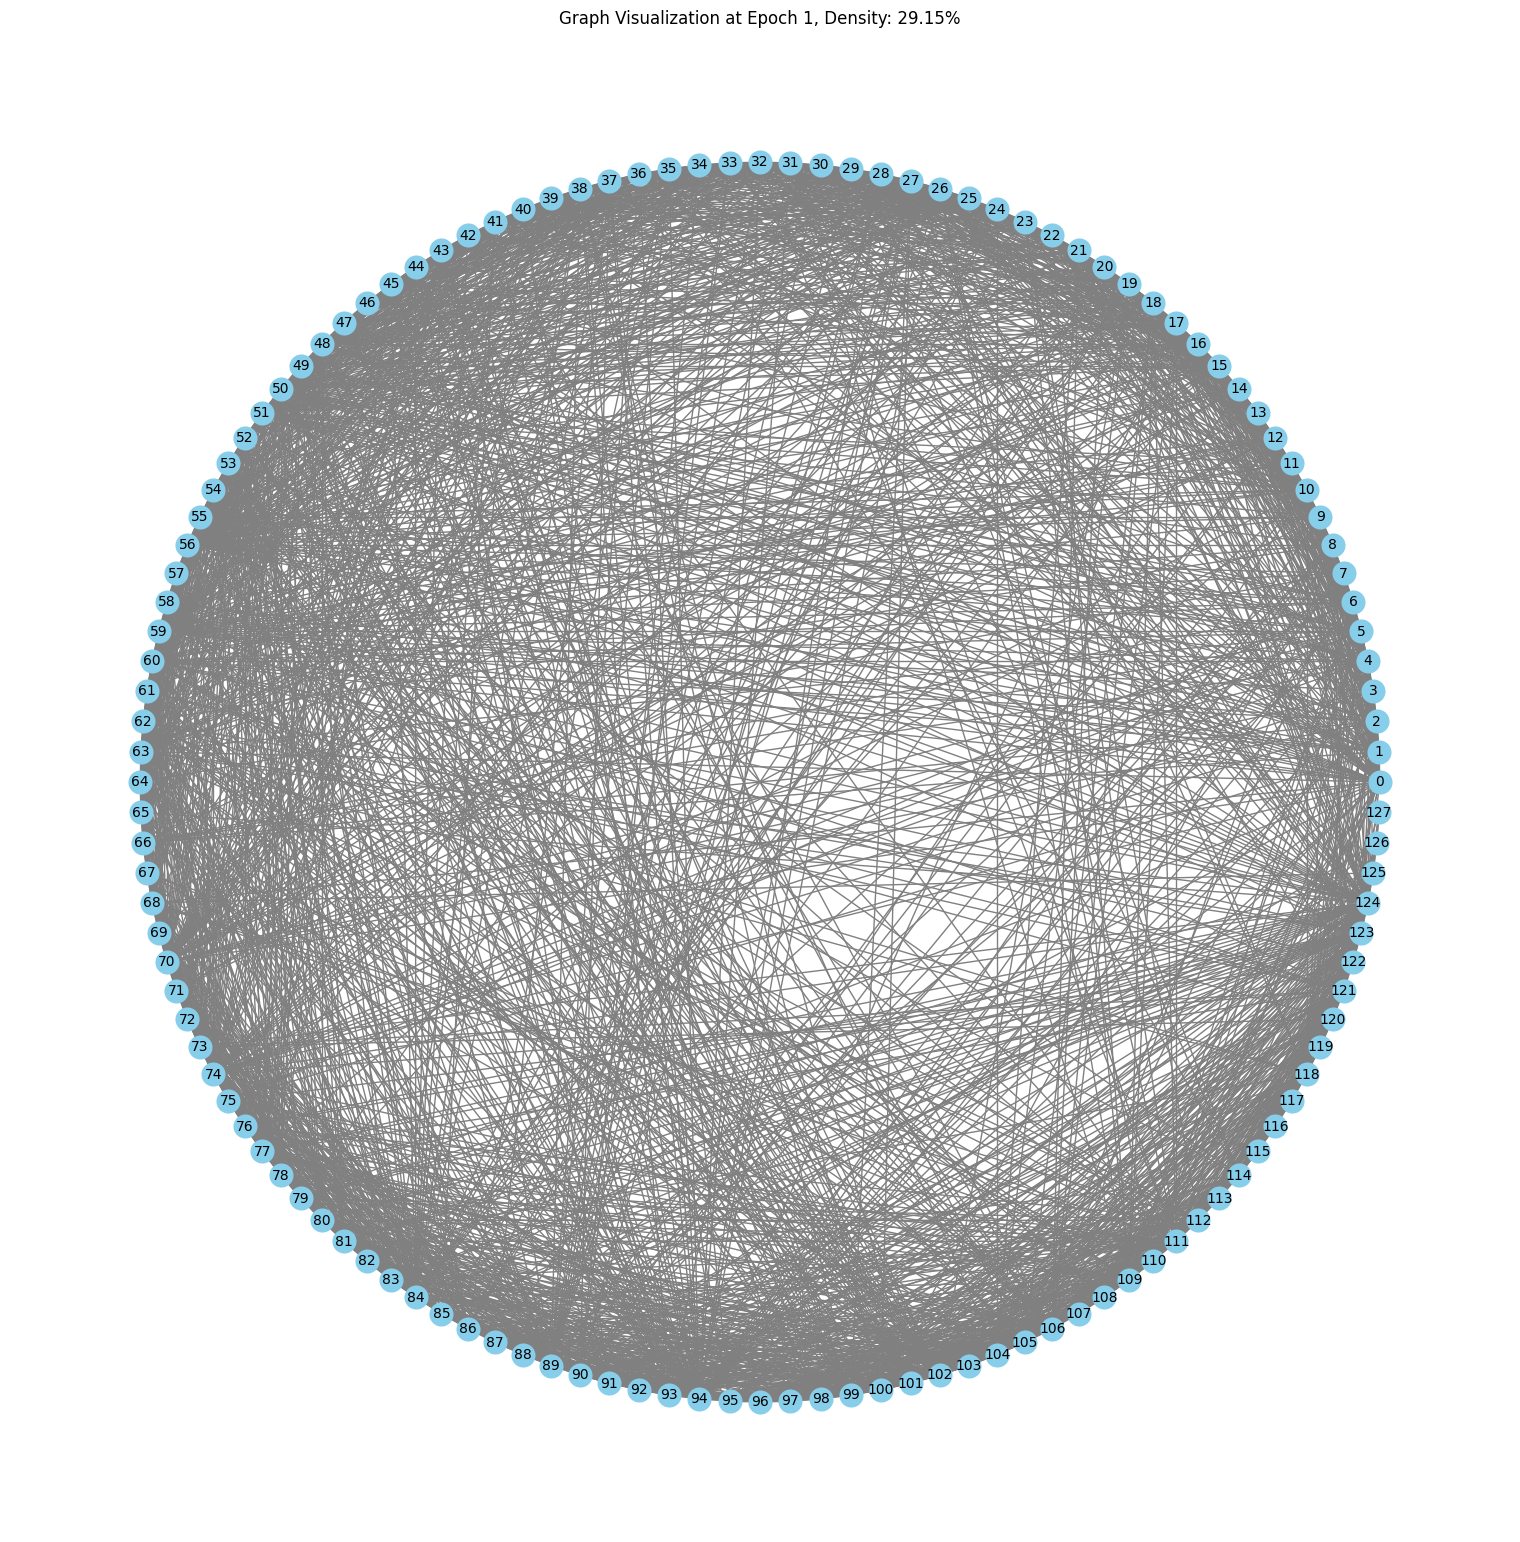

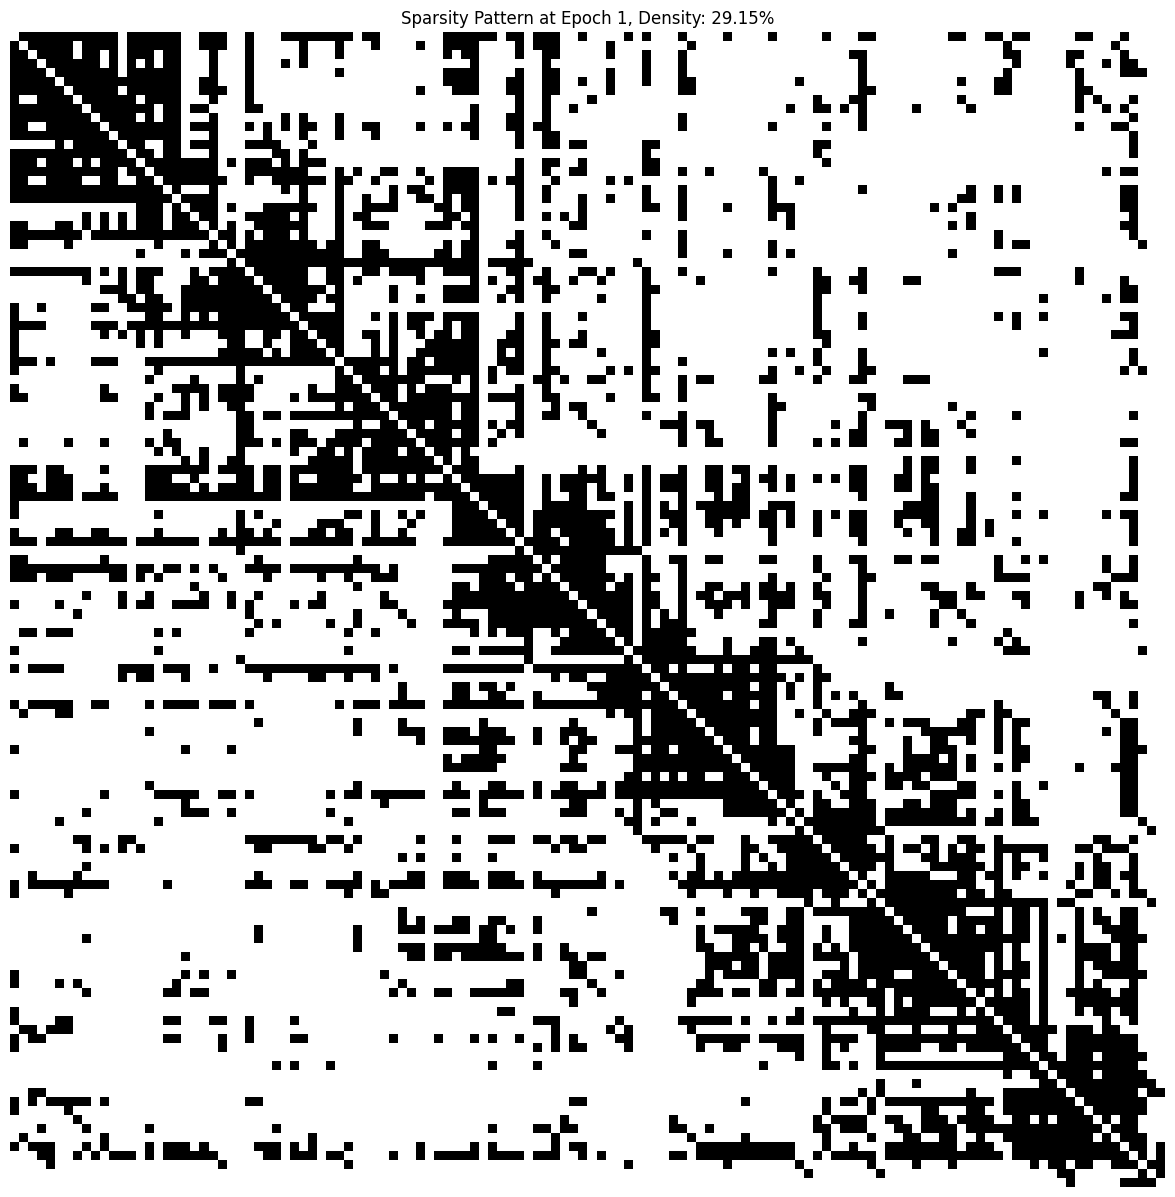

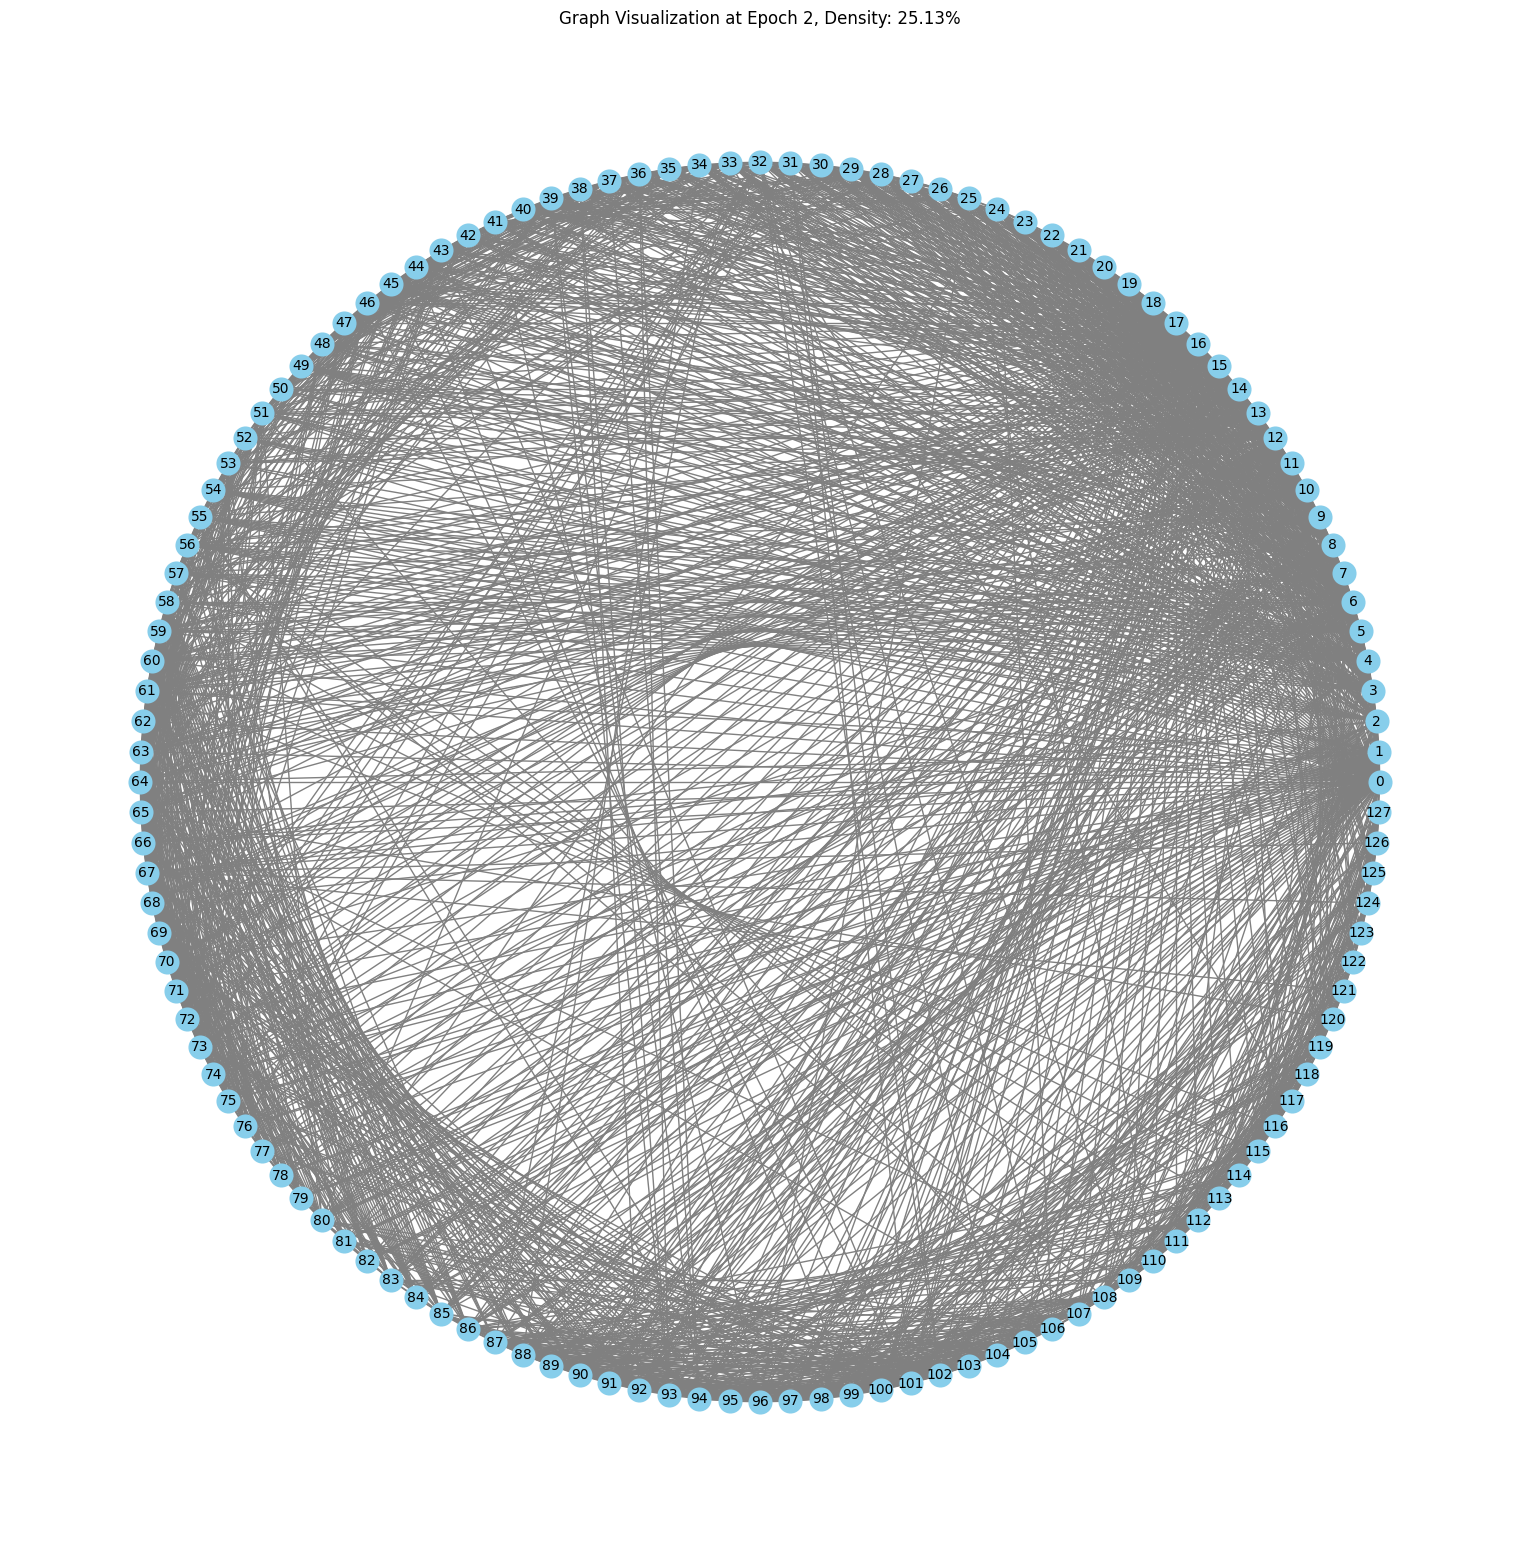

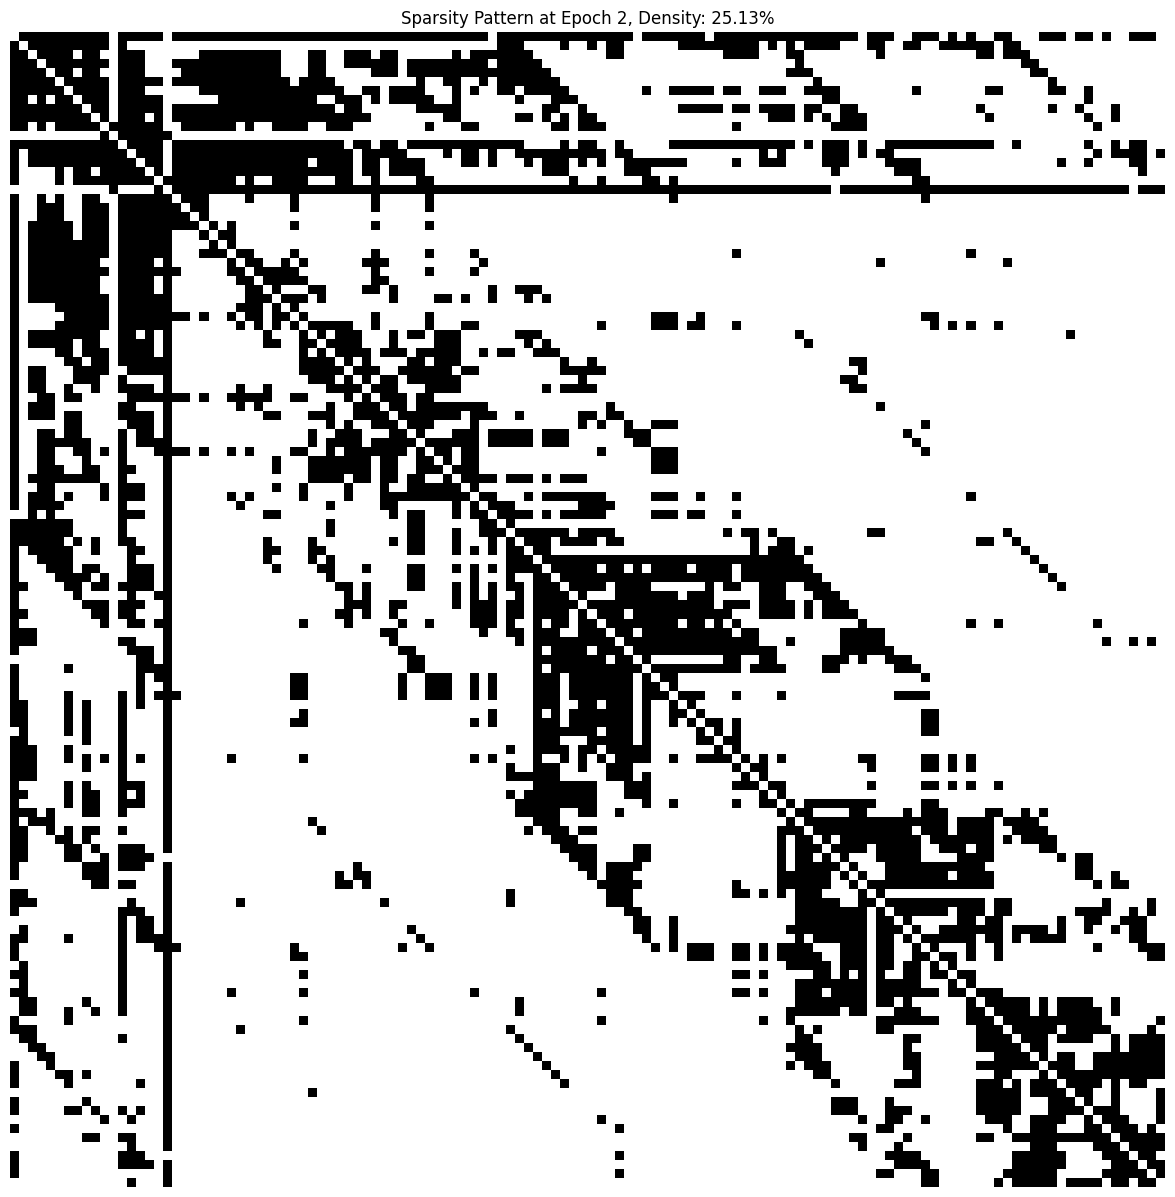

In [71]:
def visualize_graph_with_fixed_positions(adj_matrices: list[np.ndarray]):
    num_nodes = len(adj_matrices[0])
    G_initial = nx.Graph()
    G_initial.add_nodes_from(range(num_nodes))
    pos = nx.circular_layout(G_initial)
    
    for i, adj_matrix in enumerate(adj_matrices):
        density = np.sum(adj_matrix != 0) / adj_matrix.size
        G = nx.from_numpy_array(adj_matrix)
        
        # Draw the graph with fixed positions
        plt.figure(figsize=(15, 15))
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', linewidths=0.01, font_size=10)
        plt.title(f"Graph Visualization at Epoch {i+1}, Density: {density:.2%}")
        plt.show()

        # Draw the sparsity map
        plt.figure(figsize=(15, 15))
        plt.imshow(adj_matrix, cmap='Greys', interpolation='nearest')
        plt.title(f'Sparsity Pattern at Epoch {i+1}, Density: {density:.2%}')
        plt.axis('off')
        plt.show()


# Visualize the graphs with fixed node positions
visualize_graph_with_fixed_positions(document_graphs)
